In [2]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Pytorch optimal planner

In [78]:
goal_point = np.array([4, 1, 0])
point_count = 100
start_point = np.array([0, 0, 0])

In [79]:
simple_trajectory = np.zeros((point_count + 2, 3))
simple_trajectory[:, 0] = np.linspace(start_point[0], goal_point[0], point_count + 2)
simple_trajectory[:, 1] = np.linspace(start_point[1], goal_point[1], point_count + 2)
simple_trajectory[:, 2] = np.linspace(start_point[2], goal_point[2], point_count + 2)

In [80]:
trajectory = torch.zeros((point_count, 3), requires_grad=True)

In [81]:
def wrap_angle(angles):
    return (angles + np.pi) % (2 * np.pi) - np.pi

def loss_function(trajectory):
    return distance_loss(trajectory) + 200 * constraint_loss(trajectory)

def distance_loss(trajectory):
    full_trajectory = torch.cat(
        [torch.tensor(start_point)[None], trajectory, torch.tensor(goal_point)[None]], dim=0)
    delta = full_trajectory[1:] - full_trajectory[:-1]
    delta_angles = delta[:, 2]
    delta_angles = wrap_angle(delta_angles)
    angle_sum = torch.sum(delta_angles.detach()) - full_trajectory[-1, 2] + full_trajectory[0, 2]
    delta[-1, 2] += angle_sum
    return torch.sum(delta ** 2)

def constraint_loss(trajectory):
    full_trajectory = torch.cat(
        [torch.tensor(start_point)[None], trajectory, torch.tensor(goal_point)[None]], dim=0)
    dx = full_trajectory[1:, 0] - full_trajectory[:-1, 0]
    dy = full_trajectory[1:, 1] - full_trajectory[:-1, 1]
    angles = full_trajectory[:-1, 2]
    deltas = dx * torch.sin(angles) - dy * torch.cos(angles)
    return torch.sum(deltas ** 2)

In [82]:
hessian = np.zeros((point_count, point_count), dtype=np.float32)
for i in range(point_count):
    hessian[i, i] = 4 
    if i > 0:
        hessian[i, i - 1] = -2
        hessian[i - 1, i] = -2
inv_hessian = torch.tensor(np.linalg.inv(hessian))

In [83]:
# trajectory = torch.zeros((point_count, 3), requires_grad=True)
trajectory = torch.tensor(simple_trajectory[1:-1].astype(np.float32), requires_grad=True)
optimizer = torch.optim.Adam([trajectory], lr=2e-2)
for i in range(500):
    optimizer.zero_grad()
    loss = loss_function(trajectory)
#     loss = distance_loss(trajectory)
    loss.backward()
    trajectory.grad = inv_hessian @ trajectory.grad
    optimizer.step()
#     print(loss.item())
print(loss.item())

0.1773039698600769


In [84]:
def plot_trajectory(trajectory):
    plt.plot(trajectory[:, 0], trajectory[:, 1])
    plt.quiver(trajectory[:, 0], trajectory[:, 1], np.cos(trajectory[:, 2]), np.sin(trajectory[:, 2]), 
               scale=15, headlength=5, headwidth=2)
    plt.gca().set_aspect('equal')

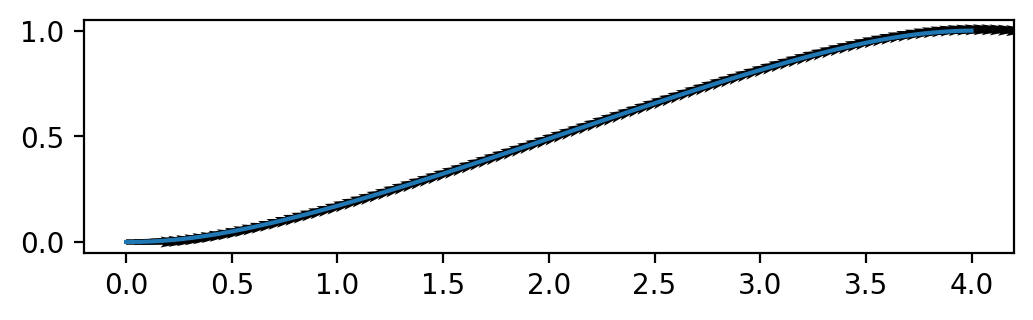

In [85]:
plt.figure(dpi=200)
plotted_trajectory = torch.cat(
    [torch.tensor(start_point)[None], trajectory, torch.tensor(goal_point)[None]], dim=0)
plot_trajectory(plotted_trajectory.cpu().detach().numpy())

# Lagrang multipliers

In [86]:
def constraint_deltas(trajectory):
    full_trajectory = torch.cat(
        [torch.tensor(start_point)[None], trajectory, torch.tensor(goal_point)[None]], dim=0)
    dx = full_trajectory[1:, 0] - full_trajectory[:-1, 0]
    dy = full_trajectory[1:, 1] - full_trajectory[:-1, 1]
    angles = full_trajectory[:, 2]
    delta_angles = wrap_angle(angles[:-1] - angles[1:])
    mean_angles = angles[:-1] + delta_angles / 2
    norm = torch.sqrt(dx ** 2 + dy ** 2 + 1e-12)
    return (dx * torch.sin(mean_angles) - dy * torch.cos(mean_angles))

In [87]:
hessian = np.zeros((point_count, point_count), dtype=np.float32)
for i in range(point_count):
    hessian[i, i] = 4 + 0.1
    if i > 0:
        hessian[i, i - 1] = -2
        hessian[i - 1, i] = -2
inv_hessian = torch.tensor(np.linalg.inv(hessian))

In [88]:
# trajectory = torch.zeros((point_count, 3), requires_grad=True)
# trajectory = torch.tensor(simple_trajectory[1:-1].astype(np.float32), requires_grad=True)
torch.random.manual_seed(200)
trajectory = torch.randn(point_count, 3, requires_grad=True)
multipliers = torch.zeros(point_count + 1, requires_grad=True)
optimizer = torch.optim.SGD([trajectory], lr=1)
for i in range(1000):
    optimizer.zero_grad()
    loss = distance_loss(trajectory) + torch.sum(multipliers * constraint_deltas(trajectory))
    loss.backward()
    trajectory.grad = inv_hessian @ trajectory.grad
    optimizer.step()
    multipliers.data.add_(1e-1 * multipliers.grad.detach())
    multipliers.grad.data.zero_()
print(loss.item())

0.17715945839881897


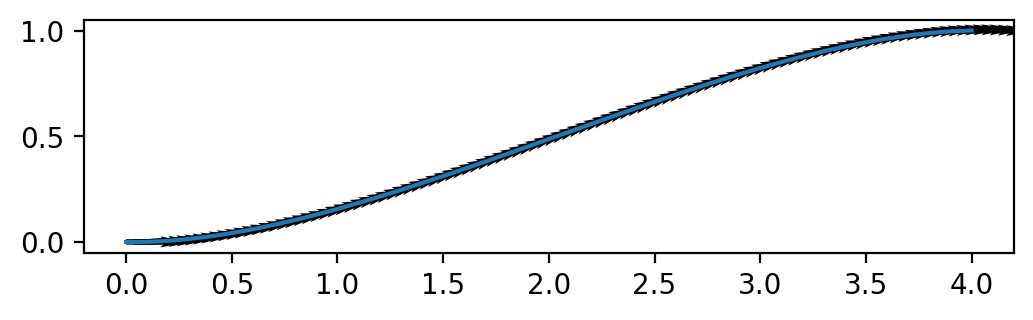

In [89]:
plt.figure(dpi=200)
plotted_trajectory = torch.cat(
    [torch.tensor(start_point)[None], trajectory, torch.tensor(goal_point)[None]], dim=0)
plot_trajectory(plotted_trajectory.cpu().detach().numpy())

# Collision function

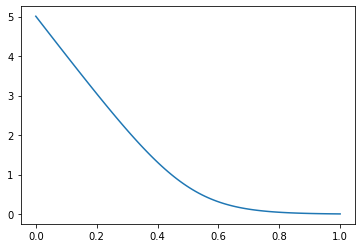

In [90]:
x = np.linspace(0, 1., 100)
y = np.log(1 + np.exp((-x + 0.5) * 10))
plt.plot(x, y)

In [91]:
def point_collision_loss(distances):
    x = (-distances + 0.5) * 10
    x = torch.stack([x, torch.zeros_like(x)], dim=1)
    x = torch.logsumexp(x, dim=1) / 200
    return x

def collision_loss(trajectory):
    collision_points = torch.tensor([[2, .5]])
    distances = torch.norm(collision_points[None] - trajectory[:, None, :2], dim=2)
    return torch.sum(point_collision_loss(distances))

In [92]:
# trajectory = torch.tensor(simple_trajectory[1:-1].astype(np.float32), requires_grad=True)
torch.random.manual_seed(404)
trajectory = torch.randn(point_count, 3, requires_grad=True)
multipliers = torch.zeros(point_count + 1, requires_grad=True)
optimizer = torch.optim.Adam([trajectory], lr=1e-1)
for i in range(3000):
    optimizer.zero_grad()
    loss = distance_loss(trajectory) + torch.sum(
        multipliers * constraint_deltas(trajectory)) + collision_loss(trajectory)
#     loss = distance_loss(trajectory) + collision_loss(trajectory)
    loss.backward()
#     trajectory.grad = inv_hessian @ trajectory.grad
    optimizer.step()
    multipliers.data.add_(1e-1 * multipliers.grad.detach())
    multipliers.grad.data.zero_()
print(loss.item())

0.2597488462924957


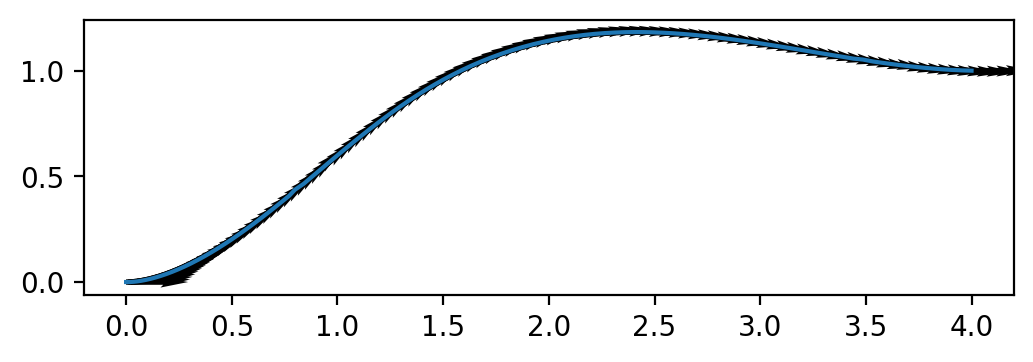

In [93]:
plt.figure(dpi=200)
plotted_trajectory = torch.cat(
    [torch.tensor(start_point)[None], trajectory, torch.tensor(goal_point)[None]], dim=0)
plot_trajectory(plotted_trajectory.cpu().detach().numpy())

# acceleration

In [101]:
def acceleration_loss(trajectory):
    full_trajectory = torch.cat(
        [torch.tensor(start_point)[None], trajectory, torch.tensor(goal_point)[None]], dim=0)
    delta = full_trajectory[1:] - full_trajectory[:-1]
    delta_angles = delta[:, 2]
    delta_angles = wrap_angle(delta_angles)
    angle_sum = torch.sum(delta_angles.detach()) - full_trajectory[-1, 2] + full_trajectory[0, 2]
    delta[-1, 2] += angle_sum
    return torch.sum((delta[1:] - delta[:-1]) ** 2)

In [38]:
def velocity_hessian(point_count):
    hessian = np.zeros((point_count, point_count), dtype=np.float32)
    for i in range(point_count):
        hessian[i, i] = 4 
        if i > 0:
            hessian[i, i - 1] = -2
            hessian[i - 1, i] = -2
    return hessian

In [39]:
def acceleration_hessian(point_count):
    hessian = np.zeros((point_count, point_count), dtype=np.float32)
    for i in range(point_count):
        hessian[i, i] = 12
        if i > 0:
            hessian[i, i - 1] = -8
            hessian[i - 1, i] = -8
        if i > 1:
            hessian[i - 2, i] = 2
            hessian[i, i - 2] = 2
    hessian[0, 0] = 10
    hessian[-1, -1] = 10
    return hessian

In [40]:
acceleration_weight = 1.
hessian = velocity_hessian(point_count) + acceleration_weight * acceleration_hessian(point_count)
inv_hessian = torch.tensor(np.linalg.inv(hessian))

In [41]:
# trajectory = torch.zeros((point_count, 3), requires_grad=True)
trajectory = torch.tensor(simple_trajectory[1:-1].astype(np.float32), requires_grad=True)
trajectory = torch.randn(point_count, 3, requires_grad=True)
multipliers = torch.zeros(point_count + 1, requires_grad=True)
optimizer = torch.optim.Adam([trajectory], lr=1e-1)
for i in range(3000):
    optimizer.zero_grad()
    loss = distance_loss(trajectory) + torch.sum(multipliers * constraint_deltas(trajectory)) +\
        acceleration_weight * acceleration_loss(trajectory) + collision_loss(trajectory) #+ 20 * constraint_loss(trajectory)
    loss.backward()
#     trajectory.grad = inv_hessian @ trajectory.grad
    optimizer.step()
    multipliers.data.add_(1e-1 * multipliers.grad.detach())
    multipliers.grad.data.zero_()
print(loss.item())

0.3217640817165375


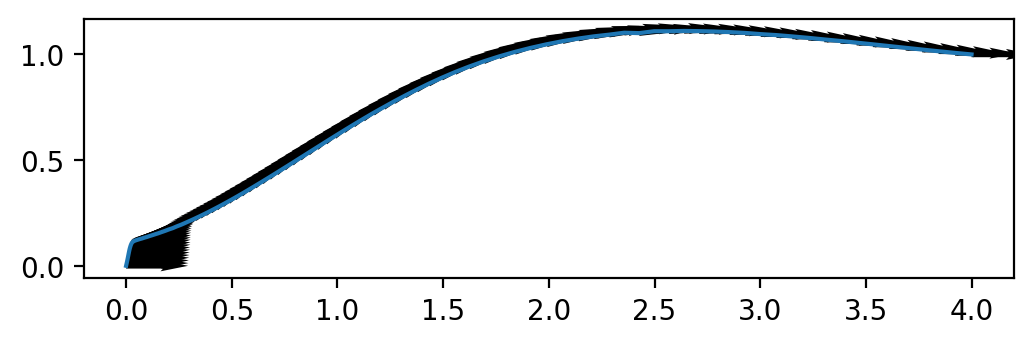

In [42]:
plt.figure(dpi=200)
plotted_trajectory = torch.cat(
    [torch.tensor(start_point)[None], trajectory, torch.tensor(goal_point)[None]], dim=0)
plot_trajectory(plotted_trajectory.cpu().detach().numpy())